# Adsorption in Zeolites with MoSDeF Cassandra

In this notebook we demonstrate how to use the [MoSDeF tools](https://mosdef.org) with the [Cassandra Monte Carlo software](https://cassandra.nd.edu) to simulate the adsorption of methane in a zeolite. The [MoSDeF Cassandra](https://mosdef-cassandra.readthedocs.io/en/latest/) package provides seamless integration between the MoSDeF tools and Cassandra. The [TraPPE-Zeo](https://pubs.acs.org/doi/10.1021/jp4074224) force field is used to model intermolecular interactions. Here we choose to use Grand Canonical Monte Carlo (GCMC), yielding a two step procedure. First, we perform GCMC simulations of pure methane at a range of chemical potential values in order to calculate the pressure of pure methane as a function of the chemical potential. Then we proceed to run GCMC of the methane and zeolite system, where the chemical potential of methane is chosen to yield some pressure of interest.

If you run all the simulations in this tutorial, it will take $\sim$20 minutes on a quad-core laptop and generate $\sim$500 MB of data.

## Preliminaries

### Installation
Everything done in this notebook is performed in a conda environment that can be created the following:

```
conda create --name mc-prod python=3.8 mosdef_cassandra matplotlib jupyter -c conda-forge
conda activate mc-prod
```

The above line also installs Cassandra. No additional steps are required. Please note that this Cassandra is only supported on Linux and OSX.

## Imports

The primary packages required are `mbuild`, `foyer`, and `mosdef_cassandra`. We use `numpy`,  `scipy`, and `matplotlib` for analysis. The `os` package `temporary_cd` function allow for directory creation. Known warnings are filtered to reduce verbosity in the example. We **do not** recommend filtering warnings in your work until you understand the meaning/implications of each.

In [1]:
import mbuild
import foyer
import mosdef_cassandra as mc
import unyt as u

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

from mosdef_cassandra.analysis import ThermoProps
from mosdef_cassandra.utils.tempdir import temporary_cd

# Filter some warnings -- to cleanup output for this demo
from warnings import filterwarnings
filterwarnings('ignore', category=UserWarning)
from parmed.exceptions import OpenMMWarning
filterwarnings('ignore', category=OpenMMWarning)

## Relating $\mu$ and $P$
Before we begin, we need to construct the mapping between the chemical potential of the adsorbate in the pure fluid phase, $\mu_\text{adsorbate}$ and pressure, $P$ at the temperature of interest. This requires performing a series of simulations of the pure fluid phase.

### Create a coarse-grained methane molecule, load and apply FF

We create a single site methane molecule in mBuild. We then load the force field from a foyer XML file and apply the force field to our methane molecule. This yields `typed_methane`, stored as a `parmed.Structure` object. 

In [2]:
methane = mbuild.Compound(name='_CH4')
ff_ads = foyer.Forcefield('resources/ffxml/adsorbates.xml')
methane_typed = ff_ads.apply(methane)

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Select a temperature and run pure fluid phase simulations

Here we choose to run at 308 K. The `custom_args` dict is used to pass additional options to Cassandra. The TraPPE force field requires a cutoff of 14.0 Angstroms. Since the adsorbate molecule (methane) is neutral, we turn off long-range electrostatics by setting the `charge_style` to `"none"`.

The range of chemical potential values is selected as -46 kJ/mol to -25 kJ/mol in increments of 3 kJ/mol. We then use [MoSDeF Cassandra](https://mosdef-cassandra.readthedocs.io/en/latest/) to run the GCMC simulations.

Larger simulation boxes (20 x 20 x 20 nm$^3$) are used for the simulations at lower values of the chemical potential to ensure that the simulation box always has $>1$ methane molecule. At higher values of the chemical potential such large simulation boxes are not required and we use a smaller simulation box (5 x 5 x 5 nm$^3$) for efficiency.

This set of simulations takes $\sim$2 minutes on a quad-core laptop.

In [3]:
temperature = 308.0 * u.K

custom_args = {
    "charge_style" : "none",
    "vdw_cutoff" : 14.0 * u.angstrom,
    "prop_freq" : 10,
}


mus_adsorbate = np.arange(-46, -25, 3) * u.kJ/u.mol

for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        species_list = [methane_typed]
        if mu_adsorbate < -34:
            boxl = 20. # nm
        else:
            boxl = 5. # nm
        box_list = [mbuild.Box([boxl,boxl,boxl])]
        system = mc.System(box_list, species_list)
        moveset = mc.MoveSet('gcmc', species_list)

        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            temperature=temperature,
            chemical_potentials = [mu_adsorbate],
            **custom_args
        )

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using the following executables for Cassandra:
Python: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/python
library_setup: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/library_setup.py
Cassandra: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/python
library_setup: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/library_setup.py
Cassandra: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/python
library_setup: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/library_setup.py
Cassandra: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/cassandra.exe
Generating fragment libraries..

### Analyze the output

We calculate the average pressure and plot the pressure as a function of the MC step. Based on the plateau in the pressure values by $\sim$ step 20000, we conservatively start calculating the average pressure at step 30000.

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


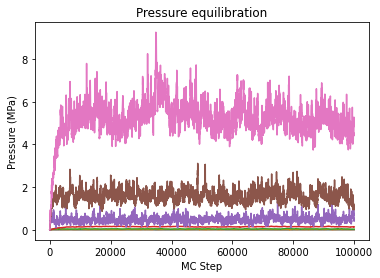

In [4]:
pressures = []
for mu_adsorbate in mus_adsorbate:
    dirname = f'pure_mu_{mu_adsorbate:.1f}'.replace(" ", "_").replace("/", "-")
    thermo = ThermoProps(dirname + "/gcmc.out.prp")
    pressures.append(np.mean(thermo.prop("Pressure", start=30000)))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Pressure").to("MPa"))
plt.title("Pressure equilibration")
plt.xlabel("MC Step")
plt.ylabel("Pressure (MPa)")
pass

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


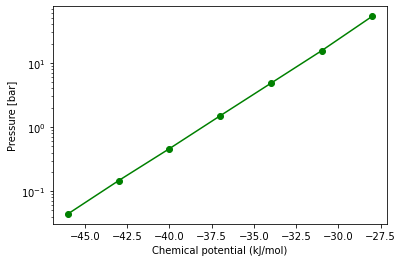

In [5]:
plt.plot(mus_adsorbate, pressures, 'go-')
plt.xlabel("Chemical potential (kJ/mol)")
plt.ylabel("Pressure [bar]")
plt.yscale('log')

### Fit $\mu$ vs. $\ln(P)$ 

In [6]:
slope, intercept, r_value, p_value, stderr = linregress(np.log(pressures).flatten(),y=mus_adsorbate.flatten())

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Calculate the required $\mu$ for a set of pressures.

 We can use our fit to calculate $\mu$ required to run at a series of pressures.

In [7]:
pressures = [
    6000   ,
    22100  ,
    49180  ,
    121800 ,
    316800 ,
    839700 ,
    2243000,
    6000000
] * u.Pa

mus = (slope * np.log(pressures.in_units(u.bar)) + intercept) * u.kJ/u.mol
for (mu, pressure) in zip(mus, pressures):
    print(f"We will run at mu = {mu:0.2f} to simulate {pressure:0.0f}")

We will run at mu = -45.21 kJ/mol to simulate 6000 Pa
We will run at mu = -41.89 kJ/mol to simulate 22100 Pa
We will run at mu = -39.85 kJ/mol to simulate 49180 Pa
We will run at mu = -37.54 kJ/mol to simulate 121800 Pa
We will run at mu = -35.10 kJ/mol to simulate 316800 Pa
We will run at mu = -32.62 kJ/mol to simulate 839700 Pa
We will run at mu = -30.11 kJ/mol to simulate 2243000 Pa
We will run at mu = -27.61 kJ/mol to simulate 6000000 Pa


/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Simulate adsorption in a zeolite

### Load a zeolite structure (MFI), load and apply FF

In [8]:
zeolite = mbuild.load('resources/pdb/MFI-expt_2x2x3.pdb')
ff_zeo = foyer.Forcefield('resources/ffxml/zeo_trappe.xml')
zeolite_typed = ff_zeo.apply(zeolite)

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Soon, mbuild will [support CIF loading](https://github.com/mosdef-hub/mbuild/pull/689), at which point loading the PDB can be replaced by the following:

```
zeolite_lattice = mbuild.lattice.load_cif('MFI.cif')
compound_dict = {
    "O" : mbuild.Compound(name="O"),
    "Si" : mbuild.Compound(name="Si")
}
zeolite = zeolite_lattice.populate(x=2, y=2, z=3, compound_dict=compound_dict)
```

### Setup a GCMC system with MoSDeF Cassandra

GCMC requires a single simulation box which contains the MFI zeolite. Thus, we use the `mbuild.Compound` zeolite as our initial box. The two species in the simulation are the MFI and our CG methane.

Our initial structure contains 1 zeolite and no methane. Since GCMC can insert molecules we do not need to add any methane to our starting structure.

In [9]:
box_list = [zeolite]
species_list = [zeolite_typed, methane_typed]

mols_in_boxes = [[1,0]]

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can now create the `mc.System` and `mc.MoveSet` objects.

In [10]:
system = mc.System(
    box_list,
    species_list,
    mols_in_boxes=mols_in_boxes,
)

moveset = mc.MoveSet('gcmc', species_list)

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Treating <Structure 3456 atoms; 1 residues; 0 bonds; PBC (orthogonal); NOT parametrized> as a non-insertable rigid species since it has no bonds


### We can view the selected move probabilities

In [11]:
moveset.print()


Ensemble:  gcmc

Probability of selecting each move type:

    Translate: 0.8
    Rotate:    0.0
    Regrow:    0.0
    Volume:    0.0
    Insert:    0.1
    Delete:    0.1
    Swap:      0.0
    Angle:     0.0
    Dihedral:  0.0

CBMC selections:

    Number of trial positions: 10
    Number of trial dihedral angles: 10
    CBMC cutoff(s): 
        Box 1: 6.0 Å


Per species quantities:

                             species1     species2     
                             ========     ========     
    Max translate (Ang):     0.00 Å          2.00 Å          (Box 1)
    Max rotate (deg):        0.00 degree         0.00 degree         (Box 1)
    Insertable:              False          True          
    Max dihedral:            0.00 degree          0.00 degree          
    Prob swap:               0.00          0.00          
    Prob regrow:             0.00          0.00          


Max volume (Ang^3):
    Box 1: 0.0 Å**3



/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Run simulations

The following set of simulations requires $\sim$15 minutes on a quad-core laptop. That can be reduced to $\sim$5 minutes by removing the three highest pressures.

In [12]:
custom_args = {
    "charge_style" : "none",
    "vdw_cutoff" : 14.0 * u.angstrom,
    "prop_freq" : 10,
    "coord_freq" : 500,
}

for (pressure, mu) in zip(pressures, mus):
    
    dirname = f"zeo_press_{pressure.value:0.0f}"
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
    else:
        pass
    with temporary_cd(dirname):
        mc.run(
            system=system,
            moveset=moveset,
            run_type="equil",
            run_length=100000,
            temperature=temperature,
            chemical_potentials = ["none", mu],
            **custom_args
        )

Using the following executables for Cassandra:
Python: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/python
library_setup: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/library_setup.py
Cassandra: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/cassandra.exe


/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/python
library_setup: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/library_setup.py
Cassandra: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/python
library_setup: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/library_setup.py
Cassandra: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/cassandra.exe
Generating fragment libraries...
Running Cassandra...
Using the following executables for Cassandra:
Python: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/python
library_setup: /Users/ryandefever/software/miniconda3/envs/mc-prod/bin/library_setup.py
Cassandra: /Users/ryandefever/software/miniconda3/envs/mc-

## Extract the results and plot

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


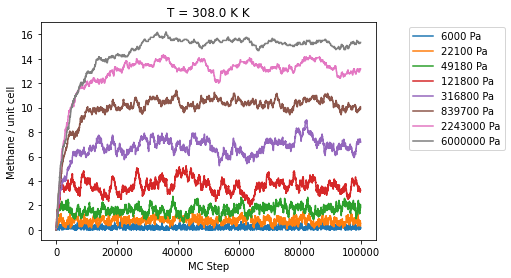

In [13]:
loading = []
for pressure in pressures:
    dirname = f"zeo_press_{pressure.value:0.0f}"
    thermo = ThermoProps(f"{dirname}/gcmc.out.prp")
    n_unitcells = 12
    loading.append(np.mean(thermo.prop("Nmols_2", start=30000)/n_unitcells))
    plt.plot(thermo.prop("MC_STEP"), thermo.prop("Nmols_2")/n_unitcells, label=f"{pressure:0.0f}")
    
plt.title(f"T = {temperature:0.1f} K")
plt.xlabel('MC Step')
plt.legend(bbox_to_anchor=(1.4, 1), loc='upper right', ncol=1)
plt.ylabel('Methane / unit cell')
plt.show()

## Comparison with literature

We can also compare our results with existing results from the [literature](https://pubs.acs.org/doi/10.1021/jp4074224). Not bad for a relatively short simulation! 

/Users/ryandefever/software/miniconda3/envs/mc-prod/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


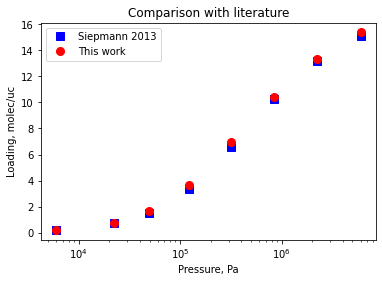

In [14]:
published_results = np.genfromtxt('resources/lit_results/tzeo_MFI-methane_308K.txt', skip_header=3)
plt.plot(published_results[:,0], published_results[:,1], 'bs', markersize=8, label="Siepmann 2013")
plt.plot(pressures, loading, 'ro', markersize=8, label="This work")
plt.title("Comparison with literature")
plt.xlabel("Pressure, Pa")
plt.ylabel("Loading, molec/uc")
plt.legend()
plt.xscale("log")

## Summary

In this notebook we showed how the MoSDeF tools can be used with Cassandra to run a series of Grand Canonical Monte Carlo simulations and model the adsorption of methane in a zeolite.